In [765]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

## Reading from SQLITE DB

In [781]:
engine = create_engine("sqlite:///Turnstiles.db")
all_tables = engine.table_names()
all_tables

['turnstile_190907']

In [783]:
data= pd.read_sql("select * from turnstile_190907",engine)
data.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,00:00:00,REGULAR,7183242,2433142
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,04:00:00,REGULAR,7183258,2433149
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,08:00:00,REGULAR,7183278,2433176
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,12:00:00,REGULAR,7183393,2433262
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/31/2019,16:00:00,REGULAR,7183572,2433312


## Reading From Source in Web

In [761]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190928,190921,190914,190907,191005,191012,191019,191026,191102,191109,191116
             ,191123,191130]
turnstiles_df = get_data(week_nums)

## Features Engineering

In [762]:
#remove space from column name
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns] 

#trasform date tp datetime datatype
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [784]:
# delete rows if desc is not regular and drop some columns
turnstiles_df=turnstiles_df.loc[turnstiles_df['DESC'] == "REGULAR"]
turnstiles_df.drop(columns={"LINENAME","DIVISION","DESC","EXITS"},inplace=True)

In [785]:
#find entries for each turnstile 
import numpy as np

turnstiles_df =turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION","DATE_TIME"])[["ENTRIES"]].sum()
turnstiles_df["FOUR_HOURS_STATION_ENTRIES"]=turnstiles_df.ENTRIES.diff()

turnstiles_df["FOUR_HOURS_STATION_ENTRIES"]=(
np.where((
    (turnstiles_df.ENTRIES ==0) & (turnstiles_df.FOUR_HOURS_STATION_ENTRIES < 0)),0 # IN CASE OF COUNTER RESET RET0 
    , 
    np.where((turnstiles_df.ENTRIES !=0) & (turnstiles_df.FOUR_HOURS_STATION_ENTRIES < 0)
             , abs(turnstiles_df.FOUR_HOURS_STATION_ENTRIES), # IN CASE OF COUNTER REVERSE RETURN ABS(DAILY_ENTRIES)
         turnstiles_df.FOUR_HOURS_STATION_ENTRIES) # IN CASE NORMAL COUNTER RETURN SAME VALUE AS DAILY_ENTRIES
))
turnstiles_df.reset_index(inplace=True)
turnstiles_df.head(7)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,FOUR_HOURS_STATION_ENTRIES
0,A002,R051,02-00-00,59 ST,2019-08-31 00:00:00,7183242,NaN
1,A002,R051,02-00-00,59 ST,2019-08-31 04:00:00,7183258,16.0
2,A002,R051,02-00-00,59 ST,2019-08-31 08:00:00,7183278,20.0
3,A002,R051,02-00-00,59 ST,2019-08-31 12:00:00,7183393,115.0
4,A002,R051,02-00-00,59 ST,2019-08-31 16:00:00,7183572,179.0
5,A002,R051,02-00-00,59 ST,2019-08-31 20:00:00,7183842,270.0
6,A002,R051,02-00-00,59 ST,2019-09-01 00:00:00,7184008,166.0


In [786]:
#add more data about the date and time
turnstiles_df["DATE"]=turnstiles_df["DATE_TIME"].dt.date
turnstiles_df["Week_Day"]=turnstiles_df["DATE_TIME"].dt.weekday
turnstiles_df["hour"]=turnstiles_df["DATE_TIME"].dt.hour

In [787]:
#drop date = 31-8-2019 because entries are cumulative and preceeding entry does not exist
turnstiles_df=turnstiles_df[turnstiles_df['DATE'] != '2019-08-31']
turnstiles_df=turnstiles_df[turnstiles_df['DATE_TIME'] != '2019-08-31 00:00:00']
turnstiles_df=turnstiles_df.loc[turnstiles_df["DATE_TIME"].dt.strftime("%d")!="31"]

# EDA

## What is the peak hour for each station?

In [757]:
stations_and_hours=turnstiles_df.groupby(["STATION","hour"])[["FOUR_HOURS_STATION_ENTRIES"]].median().reset_index()
#drop the outliers
stations_and_hours=stations_and_hours[stations_and_hours["FOUR_HOURS_STATION_ENTRIES"]<200000]
stations_and_hours_max=stations_and_hours.groupby(["STATION"])[["FOUR_HOURS_STATION_ENTRIES"]].max()
merged=pd.merge(stations_and_hours_max,stations_and_hours,on=["STATION","FOUR_HOURS_STATION_ENTRIES"])
merged.sort_values(by="FOUR_HOURS_STATION_ENTRIES",ascending=False).head(10)

,STATION,FOUR_HOURS_STATION_ENTRIES,hour
226,FT HAMILTON PKY,2382.5,11
421,YORK ST,1727.0,20
302,MYRTLE AV,1255.0,12
124,ASTORIA DITMARS,1126.5,11
7,116 ST-COLUMBIA,1106.0,20
56,30 AV,1062.5,11
234,GRD CNTRL-42 ST,1031.0,14
192,CORTELYOU RD,1021.0,11
261,JUNIUS ST,958.0,9
67,42 ST-BRYANT PK,872.0,20


## peak hours on Saturdays

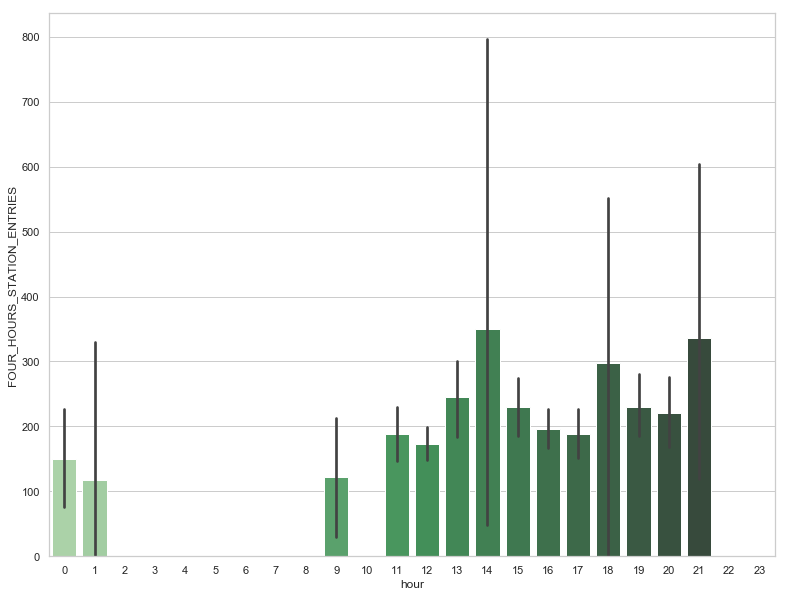

In [759]:
stations_df_Saturdays=turnstiles_df.loc[turnstiles_df["Week_Day"]==5]
stations_df_Saturdays=stations_df_Saturdays.groupby(["STATION","hour"]).FOUR_HOURS_STATION_ENTRIES.median().reset_index()
stations_df_Saturdays_max=stations_df_Saturdays.groupby(["STATION"])[["FOUR_HOURS_STATION_ENTRIES"]].max()
merged_saturday=pd.merge(stations_df_Saturdays_max,stations_df_Saturdays,on=["STATION","FOUR_HOURS_STATION_ENTRIES"])

ax = sns.barplot(x=merged_saturday["hour"], y=merged_saturday["FOUR_HOURS_STATION_ENTRIES"],palette="Greens_d")


## peak hours on Thursdays

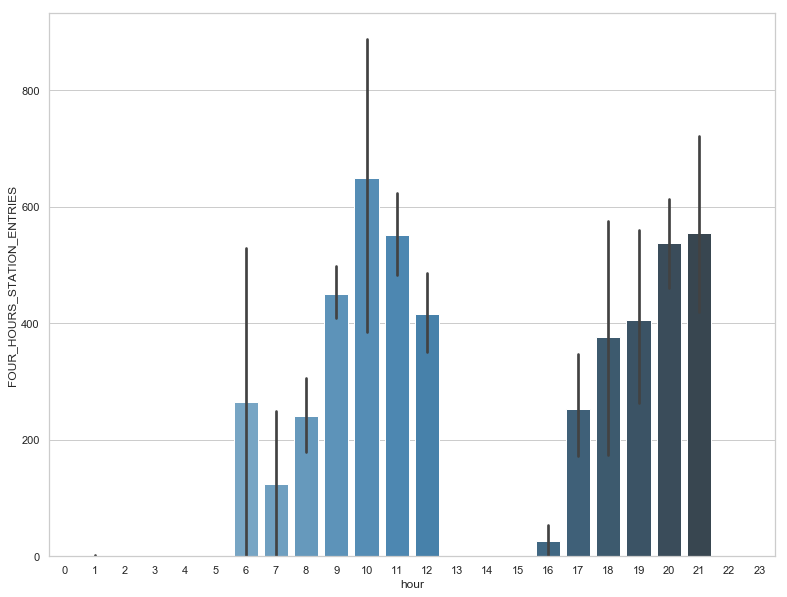

In [760]:
stations_df_Thursdays=turnstiles_df.loc[turnstiles_df["Week_Day"]==3]
stations_df_Thursdays=stations_df_Thursdays.groupby(["STATION","hour"]).FOUR_HOURS_STATION_ENTRIES.median().reset_index()
stations_df_Thursdays_max=stations_df_Thursdays.groupby(["STATION"])[["FOUR_HOURS_STATION_ENTRIES"]].max()
merged_Thursdays=pd.merge(stations_df_Thursdays_max,stations_df_Thursdays,on=["STATION","FOUR_HOURS_STATION_ENTRIES"])

ax = sns.barplot(x=merged_Thursdays["hour"], y=merged_Thursdays["FOUR_HOURS_STATION_ENTRIES"],palette="Blues_d")

## Grouping the data into stations and days with sum entries of each station in each day

In [439]:
turnstiles_df_stations_per_day=turnstiles_df.groupby(["STATION","DATE"]).FOUR_HOURS_STATION_ENTRIES.sum()
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.reset_index()

In [440]:
#rename column of entries
turnstiles_df_stations_per_day.rename(columns={'FOUR_HOURS_STATION_ENTRIES':'DAILY_ENTRIES'},inplace=True)

In [441]:
#drop outliers
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['DAILY_ENTRIES']<195000]

In [442]:
#drop stations with many outliers "GRD CNTRL-42 ST","BOTANIC GARDEN","THIRTY ST","THIRTY THIRD ST","GROVE STREET" "PATH NEW WTC"
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="GRD CNTRL-42 ST"]
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="BOTANIC GARDEN"]
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="THIRTY ST"]
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="THIRTY THIRD ST"]
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="GROVE STREET"]
turnstiles_df_stations_per_day=turnstiles_df_stations_per_day.loc[turnstiles_df_stations_per_day['STATION'] !="PATH NEW WTC"]

## What is the station having in average more concentration daily? 

In [752]:
turnstiles_df_stations_avg=turnstiles_df_stations_per_day.groupby('STATION')[['DAILY_ENTRIES']].mean().reset_index()
most_crowded_Stations=turnstiles_df_stations_avg.sort_values(by='DAILY_ENTRIES',ascending=False).head(20)
least_crowded_Stations=turnstiles_df_stations_avg.sort_values(by='DAILY_ENTRIES',ascending=True).head(20)
most_crowded_Stations.head(20)

,STATION,DAILY_ENTRIES
61,34 ST-PENN STA,147392.000000
59,34 ST-HERALD SQ,110704.280899
46,23 ST,104903.317647
68,42 ST-PORT AUTH,92430.191011
14,14 ST-UNION SQ,90695.988636
346,TIMES SQ-42 ST,89994.775281
224,FULTON ST,82314.505882
110,86 ST,76909.179775
9,125 ST,72560.482759
86,59 ST COLUMBUS,67960.141176


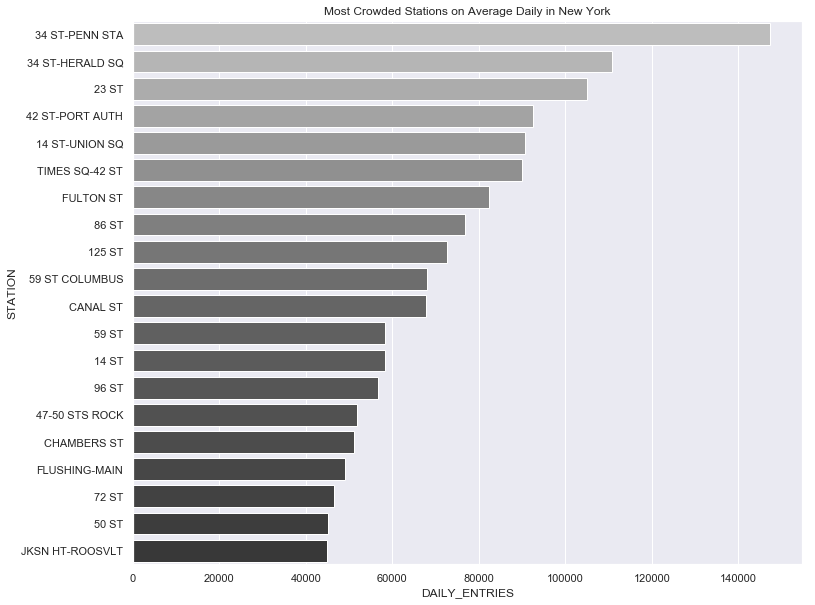

In [662]:
ax = sns.barplot( y=most_crowded_Stations['STATION'],x=most_crowded_Stations['DAILY_ENTRIES'],
                 palette="Greys_d")
ax.set(title="Most Crowded Stations on Average Daily in New York")
sns.set(rc={'figure.figsize':(12,10)})

### The Station 34 ST-PENN STA has on average the highest concentration daily. So lets see what are the peak days and days in this station.

In [679]:
station_34_ST_PENN_STA=turnstiles_df.loc[turnstiles_df["STATION"]=="34 ST-PENN STA"]
station_34_ST_PENN_STA=station_34_ST_PENN_STA.groupby(["DATE"])[["FOUR_HOURS_STATION_ENTRIES"]].sum().reset_index()
station_34_ST_PENN_STA.sort_values(by="FOUR_HOURS_STATION_ENTRIES",ascending=False).head(10)

,DATE,FOUR_HOURS_STATION_ENTRIES
68,2019-11-09,9946134.0
34,2019-10-05,1167165.0
17,2019-09-18,234401.0
32,2019-10-03,194731.0
46,2019-10-17,185811.0
54,2019-10-25,184930.0
59,2019-10-30,183637.0
58,2019-10-29,182839.0
65,2019-11-06,182361.0
80,2019-11-21,181666.0


## Grouping the data based on stations and week day to get average of entries in a staion in each week day

In [443]:
#add week day to each record
turnstiles_df_stations_per_day["DATE"]=pd.to_datetime(turnstiles_df_stations_per_day.DATE)
turnstiles_df_stations_per_day["DAY_OF_WEEK"]=turnstiles_df_stations_per_day["DATE"].dt.weekday
turnstiles_df_stations_per_day.head(10)

,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-09-01,4282.0,6
1,1 AV,2019-09-02,3733.0,0
2,1 AV,2019-09-03,14574.0,1
3,1 AV,2019-09-04,16428.0,2
4,1 AV,2019-09-05,18734.0,3
5,1 AV,2019-09-06,19451.0,4
6,1 AV,2019-09-07,7627.0,5
7,1 AV,2019-09-08,5989.0,6
8,1 AV,2019-09-09,16915.0,0
9,1 AV,2019-09-10,18190.0,1


In [444]:
#map day of week with words
d={0:"Monday",1:"Tuesday",2:"Wednesday", 3:'Thursday',4:"Friday",5:"Saturday",6:"Sunday"}

turnstiles_df_stations_per_day.DAY_OF_WEEK=turnstiles_df_stations_per_day.DAY_OF_WEEK.map(lambda x:d[x])

In [445]:
turnstiles_df_stations_average_week_day=turnstiles_df_stations_per_day.groupby(["STATION","DAY_OF_WEEK"]).DAILY_ENTRIES.median()
turnstiles_df_stations_average_week_day=turnstiles_df_stations_average_week_day.reset_index()
turnstiles_df_stations_average_week_day.rename(columns={'DAILY_ENTRIES':'AVERAGE_ENTRIES'},inplace=True)
turnstiles_df_stations_average_week_day.head(10)

,STATION,DAY_OF_WEEK,AVERAGE_ENTRIES
0,1 AV,Friday,19627.0
1,1 AV,Monday,16886.0
2,1 AV,Saturday,7472.0
3,1 AV,Sunday,5045.0
4,1 AV,Thursday,19185.0
5,1 AV,Tuesday,18190.0
6,1 AV,Wednesday,18761.0
7,103 ST,Friday,32597.0
8,103 ST,Monday,29985.0
9,103 ST,Saturday,19756.0


## What is the peak day of week for each station?

In [446]:
temp_df=turnstiles_df_stations_average_week_day.groupby(["STATION"]).AVERAGE_ENTRIES.max().reset_index()
station_peak_day=pd.merge(temp_df,turnstiles_df_stations_average_week_day,on=['STATION','AVERAGE_ENTRIES'])
station_peak_day.head(10)

,STATION,AVERAGE_ENTRIES,DAY_OF_WEEK
0,1 AV,19627.0,Friday
1,103 ST,32982.0,Thursday
2,103 ST-CORONA,21530.0,Friday
3,104 ST,4765.0,Wednesday
4,110 ST,11747.0,Friday
5,111 ST,17341.0,Wednesday
6,116 ST,35617.5,Friday
7,116 ST-COLUMBIA,18941.0,Thursday
8,121 ST,2490.5,Thursday
9,125 ST,86023.0,Friday


[Text(0.5, 1.0, 'Peak Days for Stations')]

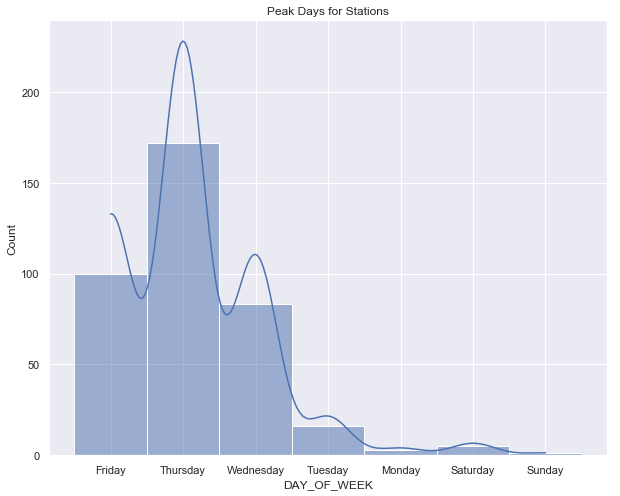

In [447]:
sns.set(rc={'figure.figsize':(10,8)})
sns.histplot(data=station_peak_day, x="DAY_OF_WEEK", stat="count",kde=True,palette = 
             sns.color_palette("husl", 3)).set(title="Peak Days for Stations")

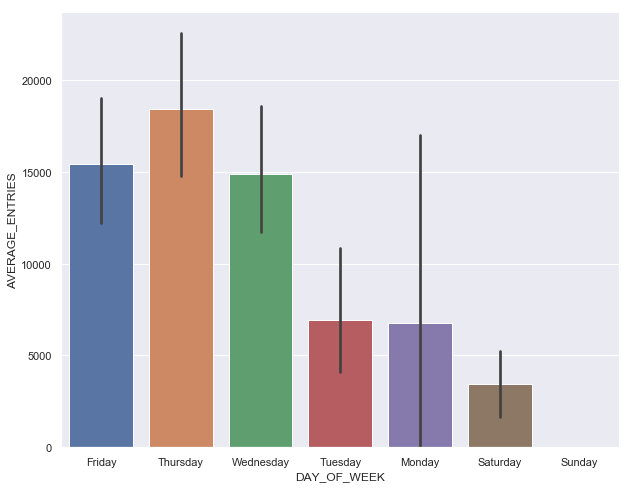

In [697]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x=station_peak_day["DAY_OF_WEEK"], y=station_peak_day["AVERAGE_ENTRIES"])

## What are the Stations with peak day = Saturday?

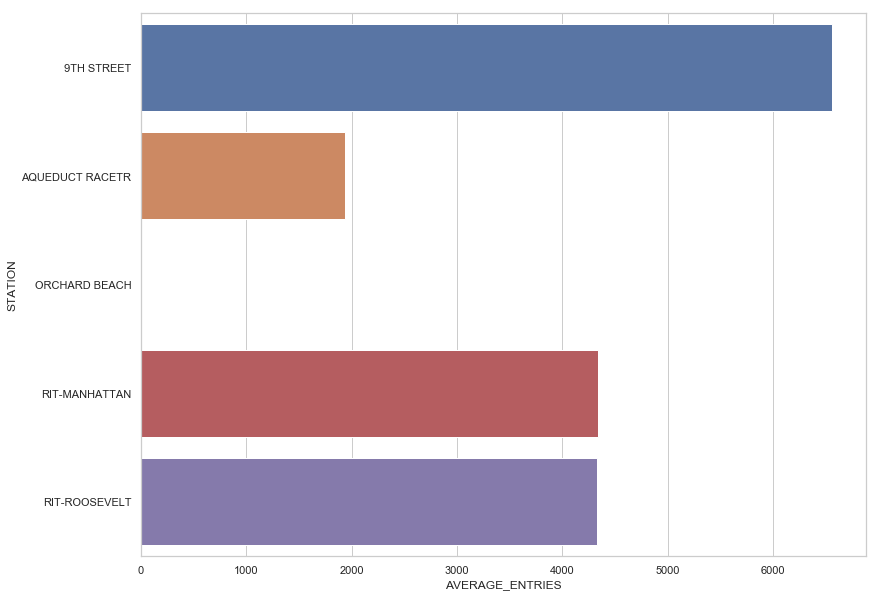

In [747]:
saturday_peaks=station_peak_day[station_peak_day["DAY_OF_WEEK"]=="Saturday"]
saturday_peaks.sort_values(by='AVERAGE_ENTRIES', ascending=False).head(10)
ax = sns.barplot(y=saturday_peaks["STATION"], x=saturday_peaks["AVERAGE_ENTRIES"])

### From the above stations , (9TH STREET) will be invistigated more, what hours excatly are the peaks in the saturdays in this stations? 

In [559]:
df_9TH_STREET=turnstiles_df.loc[turnstiles_df["STATION"]=="9TH STREET"]

#drop outliers
df_9TH_STREET=df_9TH_STREET.loc[df_9TH_STREET["FOUR_HOURS_STATION_ENTRIES"]<2000]
df_9TH_STREET.drop(columns={"C/A","UNIT","SCP","STATION","ENTRIES","DATE","Week_Day","hour","day_of_month"},inplace=True)
df_9TH_STREET.head(5)

,DATE_TIME,FOUR_HOURS_STATION_ENTRIES
1562636,2019-09-01 02:30:39,121.0
1562637,2019-09-01 06:42:39,12.0
1562638,2019-09-01 10:54:39,12.0
1562639,2019-09-01 15:06:39,53.0
1562640,2019-09-01 19:18:39,145.0


In [562]:
df_9TH_STREET["hour"]=df_9TH_STREET["DATE_TIME"].dt.hour
df_9TH_STREET_AVG_hour=df_9TH_STREET.groupby(["hour"])[["FOUR_HOURS_STATION_ENTRIES"]].mean().reset_index()
df_9TH_STREET_AVG_hour.FOUR_HOURS_STATION_ENTRIES.max()

465.7232142857143

### Lets compare the peak hours between a station having peak day as saturday "9TH STREET" and a station having peak day as Monday "	SOUTH FERRY"

In [563]:
df_SOUTH_FERRY=turnstiles_df.loc[turnstiles_df["STATION"]=="SOUTH FERRY"]
df_SOUTH_FERRY.sort_values(by="FOUR_HOURS_STATION_ENTRIES",ascending=False)

#drop outliers
df_SOUTH_FERRY=df_SOUTH_FERRY.loc[df_SOUTH_FERRY["FOUR_HOURS_STATION_ENTRIES"]<3000]
df_SOUTH_FERRY.drop(columns={"C/A","UNIT","SCP","STATION","ENTRIES","DATE","Week_Day"
                             ,"day_of_month"},inplace=True)



#finding average for each hour
df_SOUTH_FERRY_AVG_hour=df_SOUTH_FERRY.groupby(["hour"])[["FOUR_HOURS_STATION_ENTRIES"]].mean().reset_index()
df_SOUTH_FERRY_AVG_hour.FOUR_HOURS_STATION_ENTRIES.max()

207.53125

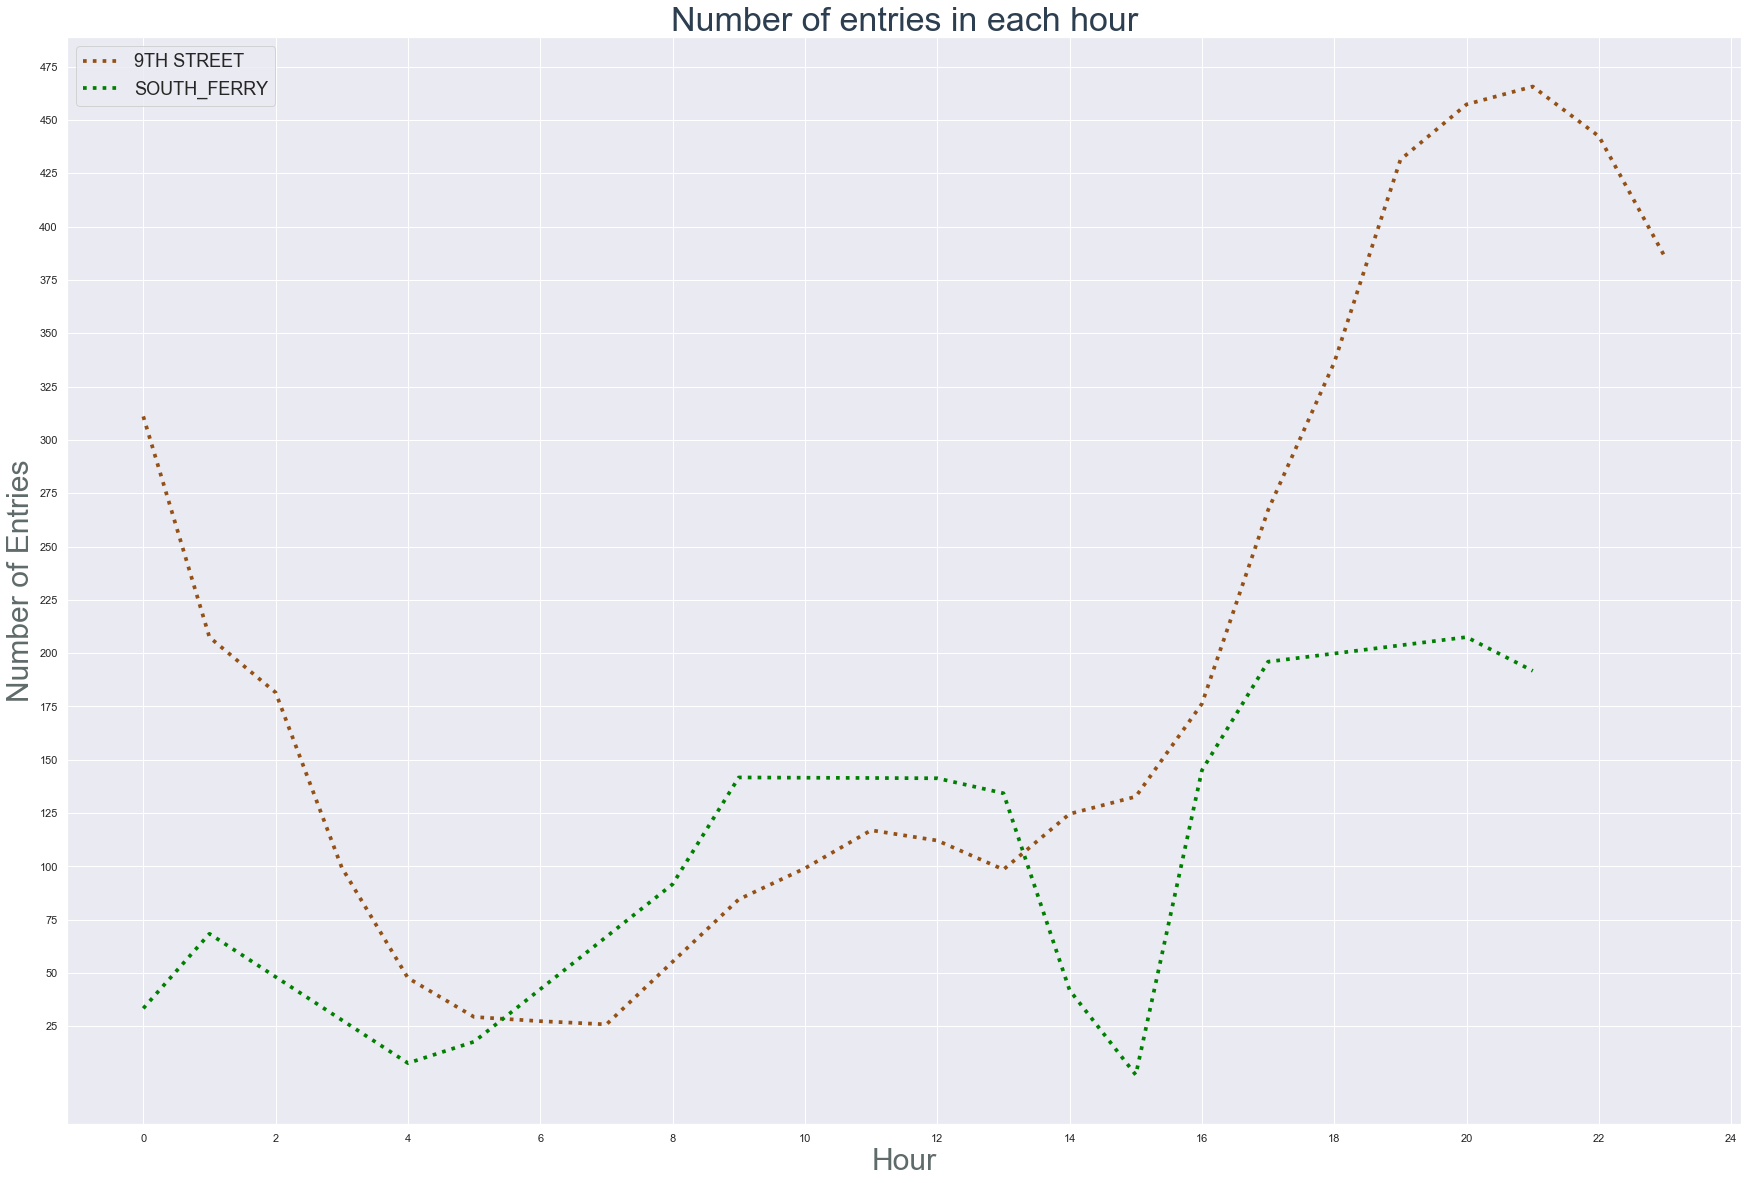

In [589]:
line1= plt.plot(df_9TH_STREET_AVG_hour.hour,df_9TH_STREET_AVG_hour.FOUR_HOURS_STATION_ENTRIES,linestyle 
         = ':',c='#935116',linewidth = 3.7)

plt.xlabel("Hour",fontsize=30,color='#5F6A6A')
plt.ylabel("Number of Entries",fontsize=30,color='#5F6A6A')
plt.title("Number of entries in each hour",fontsize=34,color='#2C3E50')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
plt.yticks([25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475])

line2 =plt.plot(df_SOUTH_FERRY_AVG_hour.hour,df_SOUTH_FERRY_AVG_hour.FOUR_HOURS_STATION_ENTRIES,linestyle 
         = ':',c='green',linewidth = 3.7)

plt.legend(['9TH STREET','SOUTH_FERRY'],fontsize=18)

## What are the Stations with peak day = Monday?

In [546]:
monday_peaks=station_peak_day[station_peak_day["DAY_OF_WEEK"]=="Monday"]
monday_peaks.sort_values(by="AVERAGE_ENTRIES",ascending=False)

,STATION,AVERAGE_ENTRIES,DAY_OF_WEEK
343,SOUTH FERRY,17039.5,Monday
99,74 ST-BROADWAY,3329.0,Monday
307,ORCHARD BEACH,0.0,Monday


## What are the Stations with peak day = Thursday?

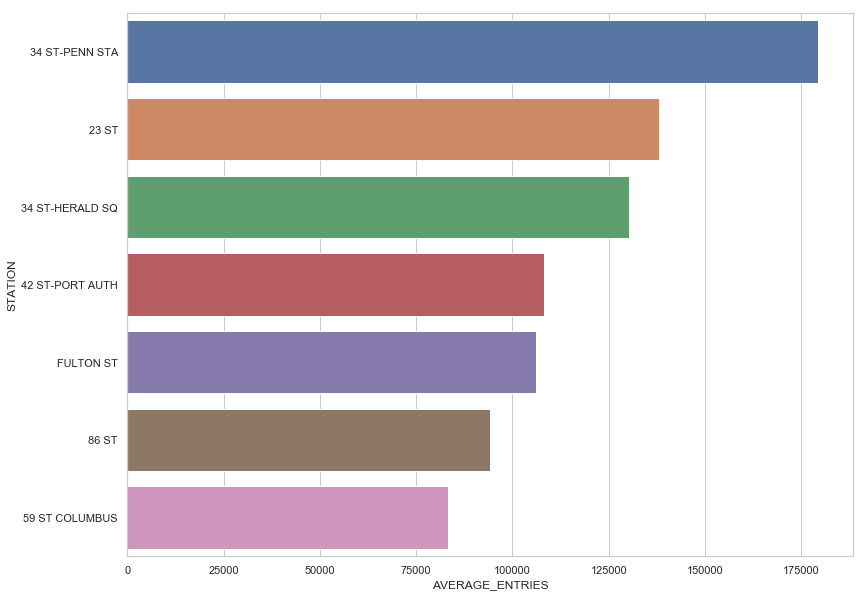

In [763]:
Thursday_peaks=station_peak_day[station_peak_day["DAY_OF_WEEK"]=="Thursday"]
to_plot=Thursday_peaks.sort_values(by="AVERAGE_ENTRIES",ascending=False).head(7)
ax = sns.barplot(y=to_plot["STATION"], x=to_plot["AVERAGE_ENTRIES"])

## What are the most crowded stations on Saturday?

In [271]:
turnstiles_df_stations_average_saturday=turnstiles_df_stations_average_week_day.loc[turnstiles_df_stations_average_week_day["DAY_OF_WEEK"]=="Saturday"]
turnstiles_df_stations_average_saturday.sort_values(by="AVERAGE_ENTRIES",ascending=False).head(15)

,STATION,DAY_OF_WEEK,AVERAGE_ENTRIES
429,34 ST-PENN STA,Saturday,94230.5
415,34 ST-HERALD SQ,Saturday,82824.0
100,14 ST-UNION SQ,Saturday,74547.0
478,42 ST-PORT AUTH,Saturday,70088.0
324,23 ST,Saturday,69943.0
2424,TIMES SQ-42 ST,Saturday,69200.0
65,125 ST,Saturday,56247.0
1199,CANAL ST,Saturday,55236.0
772,86 ST,Saturday,53850.5
604,59 ST COLUMBUS,Saturday,53393.0


## What are the least crowded stations on Saturday?

In [272]:
turnstiles_df_stations_average_saturday.sort_values(by="AVERAGE_ENTRIES",ascending=True).head(15)

,STATION,DAY_OF_WEEK,AVERAGE_ENTRIES
2137,ORCHARD BEACH,Saturday,0.0
2074,NEWARK HM HE,Saturday,3.0
2431,TOMPKINSVILLE,Saturday,59.0
982,BEACH 105 ST,Saturday,81.5
1122,BROAD CHANNEL,Saturday,133.5
1031,BEACH 98 ST,Saturday,216.0
2179,PATH WTC 2,Saturday,338.0
1003,BEACH 44 ST,Saturday,436.5
2298,ROCKAWAY PARK B,Saturday,455.5
842,AQUEDUCT N.COND,Saturday,458.5


## What are the most crowded stations on Monday?

In [273]:
turnstiles_df_stations_average_monday=turnstiles_df_stations_average_week_day.loc[turnstiles_df_stations_average_week_day["DAY_OF_WEEK"]=="Monday"]
turnstiles_df_stations_average_monday.sort_values(by="AVERAGE_ENTRIES",ascending=False).head(15)

,STATION,DAY_OF_WEEK,AVERAGE_ENTRIES
428,34 ST-PENN STA,Monday,170079.0
323,23 ST,Monday,118845.5
414,34 ST-HERALD SQ,Monday,118333.0
477,42 ST-PORT AUTH,Monday,103988.0
1569,FULTON ST,Monday,97641.0
99,14 ST-UNION SQ,Monday,96082.0
2423,TIMES SQ-42 ST,Monday,94825.0
771,86 ST,Monday,85809.0
64,125 ST,Monday,79616.0
603,59 ST COLUMBUS,Monday,73445.0


## What are the least crowded stations on Monday?

In [274]:
turnstiles_df_stations_average_monday.sort_values(by="AVERAGE_ENTRIES",ascending=True).head(15)

,STATION,DAY_OF_WEEK,AVERAGE_ENTRIES
2136,ORCHARD BEACH,Monday,0.0
2073,NEWARK HM HE,Monday,8.0
981,BEACH 105 ST,Monday,225.0
1121,BROAD CHANNEL,Monday,328.0
1030,BEACH 98 ST,Monday,447.0
2297,ROCKAWAY PARK B,Monday,648.0
2430,TOMPKINSVILLE,Monday,694.0
1002,BEACH 44 ST,Monday,705.0
1023,BEACH 90 ST,Monday,777.0
841,AQUEDUCT N.COND,Monday,938.0


General observations: 
- The following station has usually more concentration everyday of the week:

1. "34 ST-PENN STA"  
2. "23 ST" 
3. "FULTON ST"
4. "TIMES SQ-42 ST"


- The following station has usually least concentration everyday of the week:
1. "BEACH 44 ST"
2. "NEPTUNE AV"
3. "21 ST"
4. "AQUEDUCT RACETR"